In [1]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [2]:
#!/usr/bin/env python
# coding: utf-8

import dcarte

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree,export_text,export_graphviz

import ast
import math
import operator

op_map = {'>=':operator.ge,'>':operator.gt,'<=':operator.le,'<':operator.lt,'==':operator.eq}




import torch
import umap
import shap
import gc


In [3]:
from utils.test_utils import make_results_filenames

#from explainer.integrad import integrad
from explainer.FPGrowth_tree import *
from explainer.rule_pattern_miner import *
from explainer.explainer_utils import *
import explainer.RuleGrowth_tree as rgtree


In [4]:
def encode_one_hot(df,col_name):
    df[col_name] = pd.Categorical(df[col_name])
    one_hot = pd.get_dummies(df[col_name])
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(col_name,axis=1)
    return df

def min_max_normalization(df,col_name,min_val=None,max_val=None):
    if min_val is None:
        min_val = df[col_name].min()
    if max_val is None:
        max_val = df[col_name].max()
    df[col_name] = (df[col_name]-min_val)/(max_val-min_val)
    return df

In [5]:
def min_max_multicols(df,col_names,min_max_df=None):
    if min_max_df is None:
        min_max_df = pd.DataFrame(columns=col_names)
        min_max_df.loc["min"] = df.loc[:,min_max_df.columns].min(axis=0)
        min_max_df.loc["max"] = df.loc[:,min_max_df.columns].max(axis=0)
    for cn in col_names:
        df = min_max_normalization(df,cn,min_max_df.loc["min",cn],min_max_df.loc["max",cn])
    return df, min_max_df

def recover_feature_raw_value(fid,fval,featur_names,raw_min_max,ntype="min_max"):
    fn = featur_names[fid]
    if ntype == "min_max":
        mx = raw_min_max.loc[:,fn].max()
        mi = raw_min_max.loc[:,fn].min()
        return fval*(mx-mi)+mi
    else:
        raise TypeError("Not yet supported type")

In [6]:

import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dpath',default='../data', help='Path to data file')
parser.add_argument('--rpath',default='../experiments/results', help='Path to save results')
parser.add_argument('--model_path',default='./results/models', help='Path to load model')
parser.add_argument('--use_phys',action='store_true', help='Use physiology data or not')
parser.add_argument('--seed',default=42,type=int, help='Random seed')
parser.add_argument('--model_name',default='ncde',type=str, help='Model name')
parser.add_argument('--device',default='cpu',type=str, help='cpu or cuda')
parser.add_argument('--side_input',action='store_true', help='Use side input to final task')
parser.add_argument('--concat_z',action='store_true', help='Concat hidden states for the final task')
parser.add_argument('--time_intensity',action='store_true', help='Add time intensity')
parser.add_argument('--intensity',action='store_true', help='Add X intensity')
parser.add_argument('--time_len',default=12,type=int, help='Length of time indices')
parser.add_argument('--hidden_channels',default=4,type=int, help='Dimension of hidden states z')
parser.add_argument('--hidden_hidden_channels',default=32,type=int, help='Dimension of hidden units of f')
parser.add_argument('--num_hidden_layers',default=4,type=int, help='Number of hidden layers of f')
parser.add_argument('--interpolate',default='cubic_spline',type=str, help='Interpolation function name')
parser.add_argument('--batch_size',default=1024,type=int, help='Batch size')
parser.add_argument('--pos_weight',default=12,type=int, help='Weight of positive class')
parser.add_argument('--max_epochs',default=500,type=int, help='Maximum epochs')
parser.add_argument('--lr',default=0.0001,type=float, help='Raw learning rate')
parser.add_argument('--K',default=5,type=int, help='K-fold cross-validation')

_StoreAction(option_strings=['--K'], dest='K', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='K-fold cross-validation', metavar=None)

In [7]:
args,_ = parser.parse_known_args()

seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)

pp = "/Users/chenyu/github/NDE-Models-DigitalHealth/"
args.dpath = pp+"data/processed/diabetes_prediction_dataset.csv"
print(args)

Namespace(dpath='/Users/chenyu/github/NDE-Models-DigitalHealth/data/processed/diabetes_prediction_dataset.csv', rpath='../experiments/results', model_path='./results/models', use_phys=False, seed=42, model_name='ncde', device='cpu', side_input=False, concat_z=False, time_intensity=False, intensity=False, time_len=12, hidden_channels=4, hidden_hidden_channels=32, num_hidden_layers=4, interpolate='cubic_spline', batch_size=1024, pos_weight=12, max_epochs=500, lr=0.0001, K=5)


In [8]:
name = os.path.join(args.rpath,'diabetes')
num_classes = 2
#output_channels = 1

In [9]:
df = pd.read_csv(args.dpath,header=1)
df.head(),df.shape

(   gender   age  hypertension  heart_disease smoking_history    bmi  \
 0  Female  80.0             0              1           never  25.19   
 1  Female  54.0             0              0         No Info  27.32   
 2    Male  28.0             0              0           never  27.32   
 3  Female  36.0             0              0         current  23.45   
 4    Male  76.0             1              1         current  20.14   
 
    HbA1c_level  blood_glucose_level  diabetes  
 0          6.6                  140         0  
 1          6.6                   80         0  
 2          5.7                  158         0  
 3          5.0                  155         0  
 4          4.8                  155         0  ,
 (100000, 9))

In [10]:
df = encode_one_hot(df,'gender')
df = encode_one_hot(df,'smoking_history')
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,Other,No Info,current,ever,former,never,not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0


In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.drop('diabetes',axis=1),df['diabetes'],test_size=0.3,random_state=seed)

In [12]:
X_train,min_max = min_max_multicols(X_train,col_names=['age','bmi','HbA1c_level','blood_glucose_level'])


In [13]:
min_max

,age,bmi,HbA1c_level,blood_glucose_level
min,0.08,10.01,3.5,80.0
max,80.00,91.82,9.0,300.0


In [14]:
# X_train = min_max_normalization(X_train,'age')
# X_train = min_max_normalization(X_train,'bmi')
# X_train = min_max_normalization(X_train,'HbA1c_level')
# X_train = min_max_normalization(X_train,'blood_glucose_level')
X_train.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,Female,Male,Other,No Info,current,ever,former,never,not current
76513,0.612112,0,0,0.211588,0.272727,0.340909,0,1,0,0,0,1,0,0,0
60406,0.799800,0,0,0.211588,0.000000,0.295455,0,1,0,0,0,0,0,1,0
27322,0.299299,0,0,0.211588,0.000000,0.227273,1,0,0,0,1,0,0,0,0
53699,0.687187,0,0,0.211588,0.545455,0.359091,1,0,0,0,1,0,0,0,0
65412,0.174174,0,0,0.134091,0.490909,0.022727,0,1,0,1,0,0,0,0,0


In [15]:
X_test,_ = min_max_multicols(X_test,col_names=min_max.columns,min_max_df=min_max)

In [16]:
X_test.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,Female,Male,Other,No Info,current,ever,former,never,not current
75721,0.161662,0,0,0.132135,0.418182,0.209091,1,0,0,1,0,0,0,0,0
80184,0.036537,0,0,0.134336,0.272727,0.295455,1,0,0,1,0,0,0,0,0
19864,0.787287,0,0,0.187141,0.000000,0.545455,0,1,0,0,0,0,1,0,0
76699,0.024024,0,0,0.090698,0.472727,0.209091,1,0,0,0,0,0,0,1,0
92991,0.411912,0,0,0.367559,0.490909,0.545455,1,0,0,0,0,0,0,0,1


In [17]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=seed)
X_over, y_over = oversampler.fit_resample(X_train, y_train)

In [18]:
log_reg = LogisticRegression(max_iter=2000,multi_class='ovr',random_state=seed)
log_reg.fit(X_over,y_over)
y_pred = log_reg.predict(X_test)


In [19]:
accuracy = log_reg.score(X_test,y_test)*100

confusion = confusion_matrix(y_test,y_pred)
precision = precision_score(y_test,y_pred,average=None)
recall = recall_score(y_test,y_pred,average=None)
accuracy,confusion,precision,recall

(88.82666666666667,
 array([[24405,  3048],
        [  304,  2243]]),
 array([0.98769679, 0.42392742]),
 array([0.88897388, 0.88064389]))

In [20]:
log_reg.coef_.shape,log_reg.intercept_

((1, 15), array([-13.3057847]))

In [21]:
baselines = gen_intgrad_baselines(X_over.values,y_over.values)
subset = gen_balanced_subset(X_train.values,y_train.values,size_per_class=int(y_train.sum()))

In [22]:
C=2

baseline_output = log_reg.predict_proba(baselines)[:,1]
subset_output,yshift,int_g = [],[],[]    
cids = np.arange(C)
for k in cids:    
    subset_output.append(log_reg.predict_proba(subset[k])[:,1])
    for kk in cids[cids!=k]:
        yshift.append(subset_output[k]-baseline_output[kk])
        int_g.append((subset[k]-baselines[kk])* log_reg.coef_)
yshift = np.concatenate(yshift)
int_g = np.vstack(int_g)

In [23]:
y_int_g = np.abs(int_g)/yshift.reshape(-1,1)

In [24]:
y_int_g.shape

(11906, 15)

In [25]:
thds = np.linspace(0.01,1.,1000)
f_n = []
for thd in thds:
    mask = np.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(axis=0)>=len(y_int_g)*0.99).sum()))
    print(f_n[-1])
    if f_n[-1][1]==1:
        break
thd = f_n[-1][0]
thd

(0.01, 10)
(0.010990990990990991, 10)
(0.011981981981981983, 10)
(0.012972972972972972, 10)
(0.013963963963963964, 10)
(0.014954954954954955, 10)
(0.015945945945945946, 10)
(0.016936936936936937, 9)
(0.01792792792792793, 9)
(0.01891891891891892, 9)
(0.01990990990990991, 9)
(0.020900900900900903, 8)
(0.02189189189189189, 7)
(0.022882882882882885, 7)
(0.023873873873873873, 7)
(0.024864864864864868, 7)
(0.025855855855855855, 7)
(0.02684684684684685, 7)
(0.027837837837837838, 7)
(0.028828828828828833, 7)
(0.02981981981981982, 7)
(0.030810810810810815, 7)
(0.0318018018018018, 7)
(0.0327927927927928, 7)
(0.033783783783783786, 7)
(0.03477477477477477, 7)
(0.03576576576576577, 7)
(0.036756756756756756, 7)
(0.03774774774774775, 7)
(0.03873873873873874, 7)
(0.03972972972972973, 7)
(0.04072072072072072, 7)
(0.041711711711711716, 6)
(0.042702702702702704, 6)
(0.0436936936936937, 6)
(0.044684684684684686, 5)
(0.04567567567567568, 5)
(0.04666666666666667, 5)
(0.047657657657657664, 5)
(0.048648648648

0.2527927927927928

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


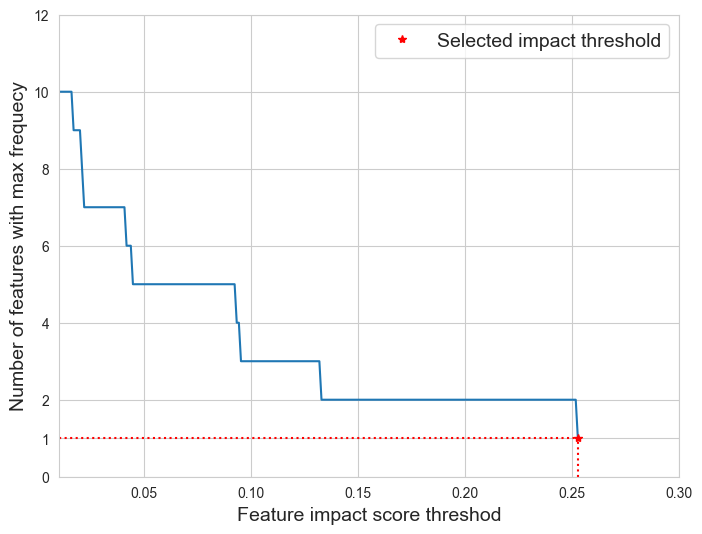

In [26]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plt.plot([th[0] for th in f_n[:]],[(th[1]) for th in f_n[:]])
plt.plot(f_n[-1][0],(f_n[-1][1]),"r*",label="Selected impact threshold")
plt.plot([0,f_n[-1][0]],[(f_n[-1][1]),(f_n[-1][1])],":r")
plt.plot([f_n[-1][0],f_n[-1][0]],[0,f_n[-1][1]],":r")
plt.xlim(0.01,.3)
plt.ylim(0.,12)
plt.yticks([0,1,2,4,6,8,10,12])
plt.xlabel("Feature impact score threshod",fontsize=14)
plt.ylabel("Number of features with max frequecy",fontsize=14)
plt.legend(fontsize=14)
plt.savefig("./results/diabetes/score_thd.eps",bbox_inches="tight")

In [27]:
itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=1500,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

[5.0] 11906.0
[5.0, 8.0] 11163.0
[5.0, 8.0, 1.0] 10361.0
[5.0, 8.0, 1.0, 6.0] 9581.0
[5.0, 8.0, 1.0, 6.0, 4.0] 7486.0
[5.0, 8.0, 1.0, 6.0, 4.0, 10.0] 3378.0
feature set [4 7 0 5 3 9] 6


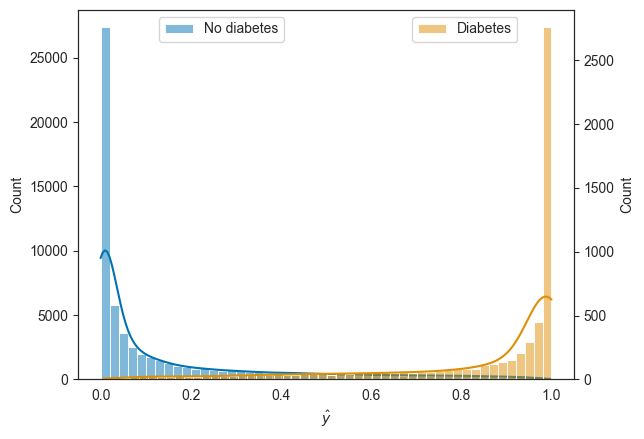

In [28]:
pred_y = log_reg.predict_proba(X_train)[:,1]

sns.set_style("white")
cmap = sns.color_palette("colorblind")
fig, ax1 = plt.subplots()
sns.histplot(pred_y[y_train==0],kde=True,ax=ax1,bins=50,color=cmap[0],label="No diabetes")
ax2 = ax1.twinx()
sns.histplot(pred_y[y_train==1],kde=True,ax=ax2,bins=50,color=cmap[1],label="Diabetes")
ax1.set_xlabel(r"$\hat{y}$")
ax1.legend(loc='upper left', bbox_to_anchor=(0.15, 1.))
ax2.legend(loc='upper right', bbox_to_anchor=(0.9, 1.))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


auc 0.9621384460095029
y threshold 0.4571048952150361


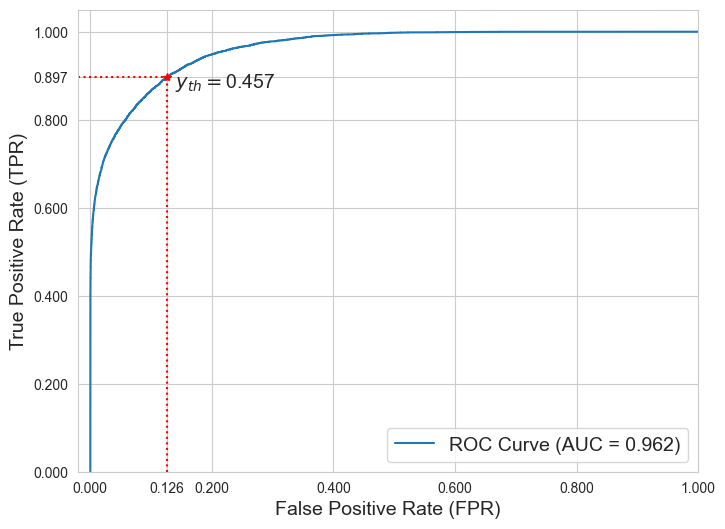

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import scipy as sp

sns.set_style("whitegrid")
auc = roc_auc_score(y_train, pred_y)
print("auc",auc)
fpr, tpr, thresholds = roc_curve(y_train, pred_y)
th_id = np.argmax(tpr - fpr)
y_thd = thresholds[th_id]
print("y threshold",y_thd)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot(fpr[th_id],tpr[th_id],"r*")
plt.annotate('$y_{th}=$'+str(y_thd.round(3)), (fpr[th_id],tpr[th_id]), textcoords='offset points', xytext=(42,-8), ha='center',fontsize=14)

plt.plot([fpr[th_id],fpr[th_id]],[0,tpr[th_id]],"r:")
plt.plot([-0.02,fpr[th_id]],[tpr[th_id],tpr[th_id]],"r:")
plt.xlim(-0.02,1.)
plt.xticks([0.,fpr[th_id],0.2,0.4,0.6,0.8,1.])
plt.yticks([0.,0.2,0.4,0.6,0.8,tpr[th_id],1.])
plt.ylim(0,1.05)
plt.xlabel('False Positive Rate (FPR)',fontsize=14)
plt.ylabel('True Positive Rate (TPR)',fontsize=14)
#plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=14)
plt.legend(fontsize=14)
plt.savefig("./results/diabetes/roc.eps",bbox_inches="tight")

plt.show()

In [30]:
y_train.sum(),y_train.shape,y_train.sum()/len(y_train),(pred_y>y_thd).sum()/len(pred_y)

(5953, (70000,), 0.08504285714285714, 0.19112857142857143)

In [31]:
pred_y_test = log_reg.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred_y_test)
auc

0.962387678432344

In [32]:
# max_s = 0.
# thd_h = 0.
# for p in np.linspace(0.6,1.,41):
#     tpr = (y_train[pred_y>=p]==1).sum()/(pred_y>=p).sum()
#     cp = (y_train[pred_y>=p]==1).sum()/(y_train==1).sum()
#     f1 = (2*tpr*cp)/(tpr+cp)
#     if f1 > max_s:
#         thd_h = p
#         max_s = f1
#     print(p,tpr,cp,f1,(pred_y>=p).sum())

In [33]:
# max_s = 0.
# thd_l = 0.
# for p in np.linspace(0.1,.4,41):
#     tpr = (y_train[pred_y<=p]==0).sum()/(pred_y<=p).sum()
#     cp = (y_train[pred_y<=p]==0).sum()/(y_train==0).sum()
#     f1 = (2*tpr*cp)/(tpr+cp)
#     if f1 > max_s:
#         thd_l = p
#         max_s = f1
#     print(p,tpr,cp,f1,(pred_y<=p).sum())

In [34]:
# def find_py_threshold(p_grids,pred_y_prob,true_y,c=1,high=True):
#     max_s = 0.
#     thd = 0.
#     if high:
#         for p in p_grids:
#             tpr = (true_y[pred_y>=p]==c).sum()/(pred_y>=p).sum()
#             cp = (y_train[pred_y>=p]==c).sum()/(y_train==c).sum()
#             f1 = (2*tpr*cp)/(tpr+cp)
#             if f1 > max_s:
#                 thd = p
#                 max_s = f1
#     else:
#         for p in p_grids:
#             tpr = (true_y[pred_y<=p]==c).sum()/(pred_y<=p).sum()
#             cp = (y_train[pred_y<=p]==c).sum()/(y_train==c).sum()
#             f1 = (2*tpr*cp)/(tpr+cp)
#             if f1 > max_s:
#                 thd = p
#                 max_s = f1
#     return thd

In [35]:
# thd_h = find_py_threshold(p_grids=np.linspace(0.6,1.,41),pred_y_prob=pred_y,true_y=y_train)
# thd_l = find_py_threshold(p_grids=np.linspace(0.1,.5,41),pred_y_prob=pred_y,true_y=y_train,c=0,high=False)

# thd_h,thd_l

In [36]:
### search rules for pred_y > y_thd  ###

import explainer.rule_pattern_miner as rlm
y_rule_candidates = rlm.gen_rule_list_for_one_target(X_train.values,fids,pred_y>y_thd,y=y_train.values,c=1,sort_by="cond_prob_y",
                                                            min_support=4000,num_grids=100,max_depth=2,top_K=3,
                                                            local_x=None,feature_types=None,
                                                            verbose=False)

for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],X_train.columns)
    y_rule_candidates[i] = rules
y_rule_candidates

build_rule_tree
init rule tree
search rule for feature 4
check potential rule 4 3.1649806118602424 0.5555555555555556 1.0 8621
add rule [] 4 (3.1649806118602424, 0.5555555555555556, 1.0, 8621)
search rule for feature 7
no valid rule,skip 7
search rule for feature 0
check potential rule 0 1.4787623482854382 0.6565656565656566 1.0 4077
add rule [4] 0 (1.4787623482854382, 0.6565656565656566, 1.0, 4077)
check potential rule 0 1.4787623482854382 0.6565656565656566 1.0 4077
add rule [4] 0 (1.4787623482854382, 0.6565656565656566, 1.0, 4077)
check potential rule 0 1.4787623482854382 0.6565656565656566 1.0 4077
add rule [4] 0 (1.4787623482854382, 0.6565656565656566, 1.0, 4077)


[{'rules': [(4, 'HbA1c_level', '>=', 0.5555555555555556),
   (0, 'age', '>=', 0.6565656565656566)],
  'cond_prob_target': 0.8945302918812853,
  'support': 4077,
  'cond_prob_y': 0.5889134167279862,
  'ratio_y': 0.4033260540903746}]

In [37]:
## recover raw feature value for the top rule set

for i, r in enumerate(y_rule_candidates[0]["rules"]):
    #print(i,r)
    nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
    y_rule_candidates[0]["rules"][i] = (*r[:-1],nr) 
y_rule_candidates[0]

{'rules': [(4, 'HbA1c_level', '>=', 6.555555555555555),
  (0, 'age', '>=', 52.552727272727275)],
 'cond_prob_target': 0.8945302918812853,
 'support': 4077,
 'cond_prob_y': 0.5889134167279862,
 'ratio_y': 0.4033260540903746}

In [39]:
### search rules for pred_y <= y_thd  ###

y_rule_candidates = rlm.gen_rule_list_for_one_target(X_train.values,fids,pred_y<=y_thd,y=y_train.values,c=0,sort_by="cond_prob_y",
                                                            min_support=20000,num_grids=100,max_depth=1,top_K=10,
                                                            local_x=None,feature_types=None,
                                                            verbose=False)
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],X_train.columns)
    y_rule_candidates[i] = rules
y_rule_candidates

build_rule_tree
init rule tree
search rule for feature 4
check potential rule 4 1.235128222119529 0.0 0.26262626262626265 21275
add rule [] 4 (1.235128222119529, 0.0, 0.26262626262626265, 21275)


[{'rules': [(4, 'HbA1c_level', '<=', 0.26262626262626265)],
  'cond_prob_target': 0.9990599294947121,
  'support': 21275,
  'cond_prob_y': 1.0,
  'ratio_y': 0.3321779318313114}]

In [40]:
## recover raw feature value for the top rule set

for i, r in enumerate(y_rule_candidates[0]["rules"]):
    #print(i,r)
    nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
    y_rule_candidates[0]["rules"][i] = (*r[:-1],nr) 
y_rule_candidates[0]

{'rules': [(4, 'HbA1c_level', '<=', 4.944444444444445)],
 'cond_prob_target': 0.9990599294947121,
 'support': 21275,
 'cond_prob_y': 1.0,
 'ratio_y': 0.3321779318313114}

In [41]:
input_feature_names =X_train.columns

In [42]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree,export_text,export_graphviz
import explainer.DT_rules as dtr
from explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

In [43]:
### otain rules for pred_y > y_thd from a DecisionTreeClassifier

treemodel = DecisionTreeClassifier(max_depth=2,min_samples_leaf=4000,random_state=seed)
treemodel.fit(X_train,pred_y>y_thd)
#y_pred_tree = treemodel.predict(X_test)
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.values,y_train.values,pred_y>y_thd,np.arange(X_train.shape[-1]),X_train.columns,c=1)
len(rule_list)

4

In [44]:
print(export_text(treemodel))

|--- feature_4 <= 0.52
|   |--- feature_5 <= 0.45
|   |   |--- class: False
|   |--- feature_5 >  0.45
|   |   |--- class: False
|--- feature_4 >  0.52
|   |--- feature_0 <= 0.54
|   |   |--- class: False
|   |--- feature_0 >  0.54
|   |   |--- class: True



In [45]:
## print rules from DecisionTreeClassifier
select = [[],[],[]]
for s in range(len(rule_list)):
    for j, r in enumerate(rule_list[s]):
        print(j,r)
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        rule_list[s][j] = (*r[:-1],nr)
    select[0].append(rule_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(input_feature_names[r[0]],r[1],r[2])

0 (4, '<=', 0.518)
1 (5, '<=', 0.455)
#################
[(4, '<=', 6.349), (5, '<=', 180.10000000000002)]
cond_prob_target 0.074 cond_prob_y 0.025 size 50417
HbA1c_level <= 6.349
blood_glucose_level <= 180.10000000000002
0 (4, '<=', 0.518)
1 (5, '>', 0.455)
#################
[(4, '<=', 6.349), (5, '>', 180.10000000000002)]
cond_prob_target 0.429 cond_prob_y 0.21 size 5082
HbA1c_level <= 6.349
blood_glucose_level > 180.10000000000002
0 (4, '>', 0.518)
1 (0, '<=', 0.543)
#################
[(4, '>', 6.349), (0, '<=', 43.47656)]
cond_prob_target 0.174 cond_prob_y 0.067 size 6357
HbA1c_level > 6.349
age <= 43.47656
0 (4, '>', 0.518)
1 (0, '>', 0.543)
#################
[(4, '>', 6.349), (0, '>', 43.47656)]
cond_prob_target 0.781 cond_prob_y 0.395 size 8144
HbA1c_level > 6.349
age > 43.47656


In [46]:
### otain rules for pred_y <= y_thd from a DecisionTreeClassifier

treemodel = DecisionTreeClassifier(max_depth=1,min_samples_leaf=25000,random_state=seed)
treemodel.fit(X_train,pred_y<=y_thd)
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.values,y_train.values,pred_y<=y_thd,np.arange(X_train.shape[-1]),X_train.columns,c=0)
len(rule_list)

2

In [47]:
print(export_text(treemodel))

|--- feature_4 <= 0.46
|   |--- class: True
|--- feature_4 >  0.46
|   |--- class: True



In [48]:
select = [[],[],[]]
for s in range(len(rule_list)):
    for j, r in enumerate(rule_list[s]):
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        rule_list[s][j] = (*r[:-1],nr)
    select[0].append(rule_list[s])
    #select[1].append(rule_value_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(input_feature_names[r[0]],r[1],r[2])

#################
[(4, '<=', 6.052)]
cond_prob_target 0.933 cond_prob_y 0.968 size 44164
HbA1c_level <= 6.052
#################
[(4, '>', 6.052)]
cond_prob_target 0.596 cond_prob_y 0.824 size 25836
HbA1c_level > 6.052


In [49]:
### otain rules for pred_y > y_thd from a DecisionTreeRegressor

treemodel = DecisionTreeRegressor(max_depth=2,min_samples_leaf=4000,random_state=seed)
treemodel.fit(X_train,pred_y)
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.values,y_train.values,pred_y>y_thd,np.arange(X_train.shape[-1]),X_train.columns,c=1)

In [50]:
print(export_text(treemodel))

|--- feature_4 <= 0.44
|   |--- feature_4 <= 0.34
|   |   |--- value: [0.02]
|   |--- feature_4 >  0.34
|   |   |--- value: [0.19]
|--- feature_4 >  0.44
|   |--- feature_0 <= 0.58
|   |   |--- value: [0.18]
|   |--- feature_0 >  0.58
|   |   |--- value: [0.60]



In [51]:
select = [[],[],[]]
for s in range(len(rule_list)):
    for j, r in enumerate(rule_list[s]):
        print(j,r)
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        rule_list[s][j] = (*r[:-1],nr)
    select[0].append(rule_list[s])
    
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(input_feature_names[r[0]],r[1],r[2])

0 (4, '<=', 0.336)
#################
[(4, '<=', 5.348)]
cond_prob_target 0.002 cond_prob_y 0.0 size 26561
HbA1c_level <= 5.348
0 (4, '<=', 0.436)
1 (4, '>', 0.336)
#################
[(4, '<=', 5.898), (4, '>', 5.348)]
cond_prob_target 0.141 cond_prob_y 0.08 size 11766
HbA1c_level <= 5.898
HbA1c_level > 5.348
0 (4, '>', 0.436)
1 (0, '<=', 0.581)
#################
[(4, '>', 5.898), (0, '<=', 46.51351999999999)]
cond_prob_target 0.12 cond_prob_y 0.046 size 16482
HbA1c_level > 5.898
age <= 46.51351999999999
0 (4, '>', 0.436)
1 (0, '>', 0.581)
#################
[(4, '>', 5.898), (0, '>', 46.51351999999999)]
cond_prob_target 0.637 cond_prob_y 0.279 size 15191
HbA1c_level > 5.898
age > 46.51351999999999


In [52]:
### otain rules for pred_y <= y_thd from a DecisionTreeRegressor

treemodel = DecisionTreeRegressor(max_depth=1,min_samples_leaf=25000,random_state=seed)
treemodel.fit(X_train,pred_y)
rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.values,y_train.values,pred_y<=y_thd,np.arange(X_train.shape[-1]),X_train.columns,c=0)

In [53]:
print(export_text(treemodel))

|--- feature_4 <= 0.44
|   |--- value: [0.07]
|--- feature_4 >  0.44
|   |--- value: [0.38]



In [54]:
select = [[],[],[]]
for s in range(len(rule_list)):
    for j, r in enumerate(rule_list[s]):
        print(j,r)
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        rule_list[s][j] = (*r[:-1],nr)
    select[0].append(rule_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(input_feature_names[r[0]],r[1],r[2])

0 (4, '<=', 0.436)
#################
[(4, '<=', 5.898)]
cond_prob_target 0.955 cond_prob_y 0.975 size 38327
HbA1c_level <= 5.898
0 (4, '>', 0.436)
#################
[(4, '>', 5.898)]
cond_prob_target 0.632 cond_prob_y 0.842 size 31673
HbA1c_level > 5.898
